In [1]:
import torch
import torch.nn as nn
import torch.optim as  optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root= './data', train= True, download = True, transform= transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 4, shuffle= True, num_workers= 2)

test_dataset = datasets.CIFAR10(root= './data', train= False, download= True, transform= transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= 4, shuffle= True, num_workers= 2)


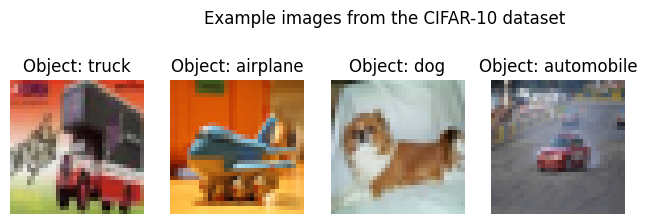

In [3]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

n = min(10, images.size(0))
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.subplot(2, 5, i + 1)
    img = images[i].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = img * 0.5 + 0.5
    plt.imshow(img)
    plt.title(f"Object: {train_dataset.classes[labels[i].item()]}")
    plt.axis('off')
plt.suptitle('Example images from the CIFAR-10 dataset')
plt.show()


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() 
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels= 32, kernel_size= 3, stride= 1, padding= 1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size= 2)

        self.conv2 = nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 3, stride= 1, padding= 1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size= 2)


        self.fc1 = nn.Linear(in_features = 64 * 8 * 8, out_features= 128 )
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features = 128, out_features= 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        x = x.view(-1, 64 * 8 * 8)

        x = self.relu4(self.fc1(x))
        x = self.fc2(x)

        return x

In [5]:
model = SimpleCNN()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

epochs = 5
train_losses, train_accuracies = [], []
print('\n Start of training: ')

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Accuracy in training: {train_accuracy:.2f}%")
print("Training complete!")


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

 Start of training: 
Epoch [1/5], Loss: 1.2870, Accuracy in training: 53.81%
Epoch [2/5], Loss: 0.9557, Accuracy in training: 66.30%
Epoch [3/5], Loss: 0.8369, Accuracy in training: 70.61%
Epoch [4/5], Loss: 0.7504, Accuracy in training: 73.36%
Epoch [5/5], Loss: 0.6763, Accuracy in training: 76.14%
Training complete!



Model accuracy on 10 000 test images: 67.87 %


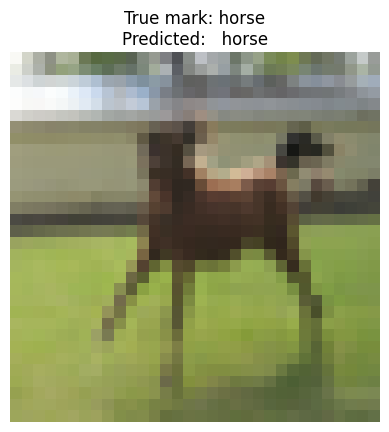

In [8]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nModel accuracy on 10 000 test images: {100 * correct / total:.2f} %')


dataiter = iter(test_loader)
images, labels = next(dataiter)

sample_image = images[0]
true_label = labels[0]

output = model(sample_image.unsqueeze(0))
_, predicted_class = torch.max(output.data, 1)

img = sample_image.cpu().numpy()
img = np.transpose(img, (1, 2, 0))
img = img * 0.5 + 0.5
plt.imshow(img)
plt.title(f'True mark: {train_dataset.classes[true_label.item()]}\nPredicted:   {train_dataset.classes[predicted_class.item()]}')
plt.axis('off')
plt.show()

In [7]:
torch.save(model.state_dict(), 'cifar-10_cnn_model.pth')